# Denise hazlo bonito

In [58]:
# Imports

# Basics
import pandas as pd
import numpy as np

# Tokenization
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, wordnet, WordNetLemmatizer
import string

# Vectorizing (if needed)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

# Preprocessing

In [59]:
nltk.download("stopwords")
nltk.download("punkt_tab")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pixta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pixta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pixta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [60]:
df = pd.read_csv('lgbt_comments.csv')
df

,id,text,anti_lgbt
0,39773,The trans women reading this tweet right now i...,0
1,11001,Sounds like the kinda wholsesome life I'd die ...,0
2,17034,Fuck off you insufferable retarded faggot.,1
3,23643,9) uhhhh i like being lgbt a lot. i feel proud...,0
4,7287,This sub is full of grade A faggots Comedy fu...,1
...,...,...,...
4294,20028,Fucking fagot burn in hell,1
4295,20051,It takes belief in false morality to commit at...,0
4296,20058,Why did I click on your profile? You gave no s...,0
4297,20060,I love that you enjoy being trans.,0


In [62]:
# Tools for pre-processing
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
lemmatizer = WordNetLemmatizer()

In [63]:
# Function for making the tokens. Takes into account that words are not punctuation, stop words, lemmatizing AND if they are fully uppercase which may be important to know
def making_tokens(text: str):
    text = text.replace('<br />', " ") # Removing line break characters so they aren't counted as tokens
    tokens = word_tokenize(text)
    processed = []
    for i in tokens:
        if i.lower() not in stop_words and i not in punctuation:
            if i.isupper() and len(i) > 1:
                processed.append(i.lower() + '_UPPER') # Because a word being all uppercase (like "us" vs "US") can be relevant information.
            else:
                processed.append(lemmatizer.lemmatize(i.lower()))
    
    return processed

In [64]:
df['tokens'] = df['text'].apply(making_tokens)

In [65]:
df

,id,text,anti_lgbt,tokens
0,39773,The trans women reading this tweet right now i...,0,"[trans, woman, reading, tweet, right, beautiful]"
1,11001,Sounds like the kinda wholsesome life I'd die ...,0,"[sound, like, kinda, wholsesome, life, 'd, die..."
2,17034,Fuck off you insufferable retarded faggot.,1,"[fuck, insufferable, retarded, faggot]"
3,23643,9) uhhhh i like being lgbt a lot. i feel proud...,0,"[9, uhhhh, like, lgbt, lot, feel, proud, done,..."
4,7287,This sub is full of grade A faggots Comedy fu...,1,"[sub, full, grade, faggot, comedy, fucking, eb..."
...,...,...,...,...
4294,20028,Fucking fagot burn in hell,1,"[fucking, fagot, burn, hell]"
4295,20051,It takes belief in false morality to commit at...,0,"[take, belief, false, morality, commit, atroci..."
4296,20058,Why did I click on your profile? You gave no s...,0,"[click, profile, gave, source, anyway, hateful..."
4297,20060,I love that you enjoy being trans.,0,"[love, enjoy, trans]"


In [66]:
# Since the original dataset only has 4300 reviews, we are only going to perform a train-test split instead of a train-dev-test split

x = df['tokens']
y = df['anti_lgbt']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Train dataset size: {X_train.shape[0]} reviews")
print(f"Test dataset size: {X_test.shape[0]} reviews")

Train dataset size: 3439 reviews
Test dataset size: 860 reviews


In [67]:
# Turns the lists of tokens into singular strings of words, to work with in the models
X_train_text = X_train.apply(lambda x: " ".join(x))
X_test_text = X_test.apply(lambda x: " ".join(x))

# Feature Extraction

Para este modelo baseline de regresión logística, vamos a usar TfidfVectorizer

In [68]:
vectorizer = TfidfVectorizer(
    ngram_range=(1,3),
    max_features=50000,     
    min_df=3,               
)

X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

In [69]:
# Modelo LR
lr = LogisticRegression(max_iter=5000, solver='saga', C=0.2, warm_start=True, random_state=42)
lr.fit(X_train_tfidf, Y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.2
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'saga'
,max_iter,5000
,multi_class,'deprecated'


In [70]:
# Predicciones
lr_preds = lr.predict(X_test_tfidf)

              precision    recall  f1-score   support

           0     0.8164    0.9949    0.8969       590
           1     0.9787    0.5111    0.6715       270

    accuracy                         0.8430       860
   macro avg     0.8976    0.7530    0.7842       860
weighted avg     0.8674    0.8430    0.8261       860



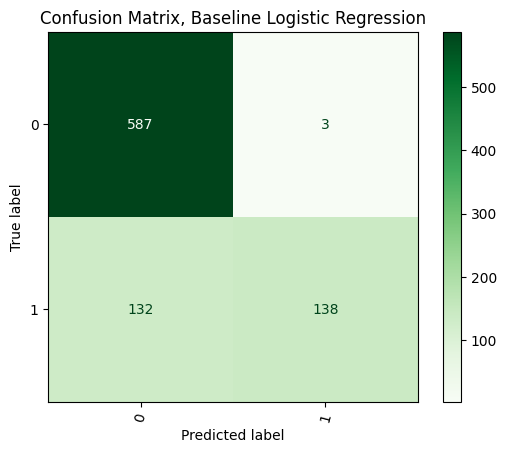

In [71]:
cm = confusion_matrix(Y_test, lr_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=lr.classes_)
disp.plot(cmap='Greens')
plt.xticks(rotation = 75)
plt.title('Confusion Matrix, Baseline Logistic Regression')
print(classification_report(Y_test, lr_preds, digits=4))
plt.show()